# UNet
A UNet consists of both encoder and decoder layers connected by skip connections, which allow information to flow freely between the two. 
Unets are often used for image-to-image tasks, such as image segmentation. Each pixel in an image is converted to another property that is more appropriate for analysis.

## The ssTEM dataset

We will segment different neuronal structures in serial section Transmission Electron Microscopy (ssTEM) images of the ventral nerve cord of the Drosophila melanogaster, a fruit fly. 
The dataset consists of 20 ssTEM images, whose size is 1024 x 1024 pixels. In addition to the ssTEM images, the dataset also contains ground-truth segmentations of the neuronal structures. 
For simplicity, we will only consider the segmentation of the neuronal intracellular regions and mitochondria.

In [1]:
import os

if not os.path.exists("tissue_images_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/tissue_images_dataset")

raw_path = os.path.join("tissue_images_dataset", "stack1", "raw")
label_path = os.path.join("tissue_images_dataset", "stack1", "labels")

In [2]:
train_images_paths = os.listdir(raw_path)

print(f"{len(train_images_paths)} training images")

20 training images


We define the data paths for the loaders.

In [3]:
import deeptrack as dt
import torch

raw_paths = dt.sources.ImageFolder(root=raw_path)
label_paths = dt.sources.ImageFolder(root=label_path)
paths = dt.sources.Source(raw=raw_paths, label=label_paths)
train_paths, val_paths, test_paths = dt.sources.random_split(paths, 
                                                             [0.8, 0.1, 0.1])

train_srcs = train_paths.product(flip_ud=[True, False], flip_lr=[True, False])  ### Ensures that all 4 combinations are made.
val_srcs = val_paths.constants(flip_ud=False, flip_lr=False)
test_srcs = test_paths.constants(flip_ud=False, flip_lr=False)

sources = dt.sources.Join(train_srcs, val_srcs, test_srcs)

We will use a function to select only the labels of the cell structures we are interested in, i.e. neuronal intracellular regions and mitochondria.

The function `select_labels` is designed to filter and remap the labels in a segmentation map according to a specified list of class labels. It takes an optional parameter `class_labels` which is a list of labels to be selected from the segmentation map. The function returns an inner function that takes a segmentation map as its input. This inner function first creates a copy of the input segmentation map to avoid modifying the original data. It then generates a mask by selecting pixels that match any of the specified `class_labels` and remaps these selected labels to a new range starting from 1 to the length of `class_labels`. This remapping is achieved using `np.select` which constructs a new segmentation map where each of the specified labels is replaced by its new value. Finally, the function returns a one-hot encoded version of this new segmentation map, where each pixel is represented as a one-hot vector indicating its class, with the vector size being one more than the number of class labels (to account for the background or unspecified labels). This approach is useful for tasks like semantic segmentation in machine learning, where a clear distinction between different classes is required.

In [4]:
import numpy as np

def select_labels(class_labels):
    """Create a function to filter and remap labels in a segmentation map."""    
    def inner(segmentation):
        seg = segmentation.copy()
        mask = seg * np.isin(seg, class_labels).astype(np.uint8)
        replace = np.arange(len(class_labels)) + 1
        new_seg = (np.select([mask == c for c in class_labels], replace)
                   .astype(np.uint8))
        return np.eye(len(class_labels) + 1)[new_seg.squeeze()]
    return inner

We define the pipeline to load, crop, and augment the images.

In [5]:
im_pipeline = dt.LoadImage(sources.raw.path) >> dt.NormalizeMinMax()
lab_pipeline = (dt.LoadImage(sources.label.path) 
                >> dt.Lambda(select_labels, class_labels=[255, 191]))
pipeline = (
    (im_pipeline & lab_pipeline)
    >> dt.FlipLR(sources.flip_lr)
    >> dt.FlipUD(sources.flip_ud)
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

We create train and test datasets and display a few image crops with the corresponding segmentation. 

In [6]:
train_dataset = dt.pytorch.Dataset(pipeline, train_srcs)
val_dataset = dt.pytorch.Dataset(pipeline, val_srcs)

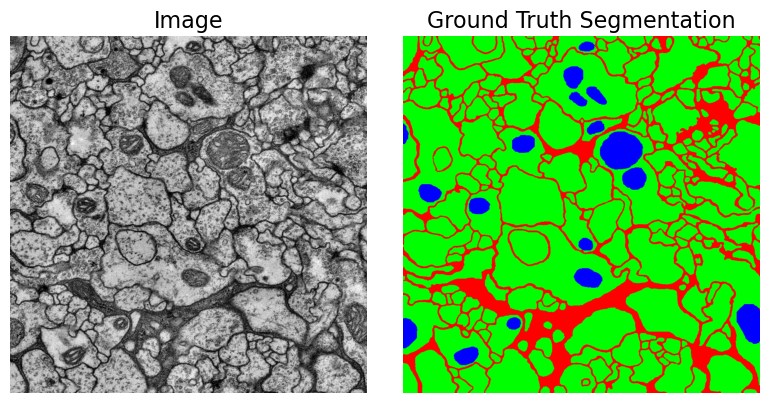

In [7]:
import matplotlib.pyplot as plt

image, label = train_dataset[0]

fig, axs = plt.subplots(1, 2, figsize=((8, 4)))
axs[0].imshow(image.permute(1, 2, 0), cmap="gray")
axs[0].set_title("Image", fontsize=16)
axs[0].set_axis_off()
axs[1].imshow(label.permute(1, 2, 0), cmap="gray")
axs[1].set_title("Ground Truth Segmentation", fontsize=16)
axs[1].set_axis_off()
plt.tight_layout()
plt.show()

We define the dataloaders...

In [8]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2)

... and the UNet

In [9]:
from torchmetrics.classification import MulticlassJaccardIndex

class ArgmaxJI(MulticlassJaccardIndex):
    """Compute Jaccard Index for multi-class predictions after argmax."""
    
    def update(self, preds, target):
        """Update Jaccard Index using argmax-applied class predictions."""
        super().update(preds.argmax(dim=1), target.argmax(dim=1))

In [10]:
import deeplay as dl

ji_metric = ArgmaxJI(num_classes=3)
        
unet = dl.UNet2d(in_channels=1, channels=[16, 32, 64, 128], out_channels=3)
unet_reg_template = dl.Regressor(model=unet,
                                 loss=torch.nn.CrossEntropyLoss(),
                                 metrics=[ji_metric], 
                                 optimizer=dl.Adam())
unet_reg = unet_reg_template.create()

In [11]:
print(unet_reg)

Regressor(
  (loss): CrossEntropyLoss()
  (train_metrics): MetricCollection(
    (ArgmaxJI): ArgmaxJI(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (ArgmaxJI): ArgmaxJI(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (ArgmaxJI): ArgmaxJI(),
    prefix=test
  )
  (model): UNet2d(
    (encoder): ConvolutionalEncoder2d(
      (blocks): LayerList(
        (0): PoolLayerActivationNormalization(
          (pool): Identity()
          (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
          (normalization): Identity()
        )
        (1): PoolLayerActivationNormalization(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
          (normalization): Identity()
        )
        (2): PoolLayerActivationNormalization(
          (pool): MaxPool2d(kerne

We train it for 100 epochs

In [12]:
from lightning.pytorch.loggers import CSVLogger

logger = CSVLogger("logs", name="train_100_epochs")

trainer = dl.Trainer(max_epochs=100, accelerator="auto", logger=logger)
trainer.fit(unet_reg, train_loader, val_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:452: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


```python
import matplotlib.pyplot as plt

def plot_training_metrics(metrics):
    """Plot training metrics."""
    fig, axs = plt.subplots(2)

    axs[0].plot(metrics["train_loss_epoch"], label="Train Loss")
    axs[0].plot(metrics["val_loss_epoch"], label="Validation Loss")
    axs[0].set_xticks([])
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    axs[1].plot(metrics["trainArgmaxJI_epoch"], label="Train Jaccard Index")
    axs[1].plot(metrics["valArgmaxJI_epoch"], label="Validation Jaccard Index")
    axs[1].set_xlabel("Step")
    axs[1].set_ylabel("Jaccard Index")
    axs[1].legend()

    plt.tight_layout()
    plt.show()
```

In [13]:
import matplotlib.pyplot as plt

def plot_training_metrics(metrics):
    """Plot training metrics."""
    fig, axs = plt.subplots(2)

    axs[0].plot(metrics["train_loss_epoch"], label="Train Loss")
    axs[0].plot(metrics["val_loss_epoch"], label="Validation Loss")
    axs[0].set_xticks([])
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    axs[1].plot(metrics["trainArgmaxJI_epoch"], label="Train Jaccard Index")
    axs[1].plot(metrics["valArgmaxJI_epoch"], label="Validation Jaccard Index")
    axs[1].set_xlabel("Step")
    axs[1].set_ylabel("Jaccard Index")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

In [14]:
def plot_training_metrics(metrics):
    """Plot training metrics by epoch."""
    fig, axs = plt.subplots(2, figsize=(10, 8))

    axs[0].plot(metrics["epoch"], metrics["train_loss_epoch"], 
                label="Train Loss")
    axs[0].plot(metrics["epoch"], metrics["val_loss_epoch"], 
                label="Validation Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    axs[1].plot(metrics["epoch"], metrics["trainArgmaxJI_epoch"], 
                label="Train Jaccard Index")
    axs[1].plot(metrics["epoch"], metrics["valArgmaxJI_epoch"], 
                label="Validation Jaccard Index")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Jaccard Index")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

/var/folders/hq/wmcbgp7s56b98c9mjf167rz40000gn/T/ipykernel_31136/328828306.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  metrics = metrics.fillna(method="ffill")


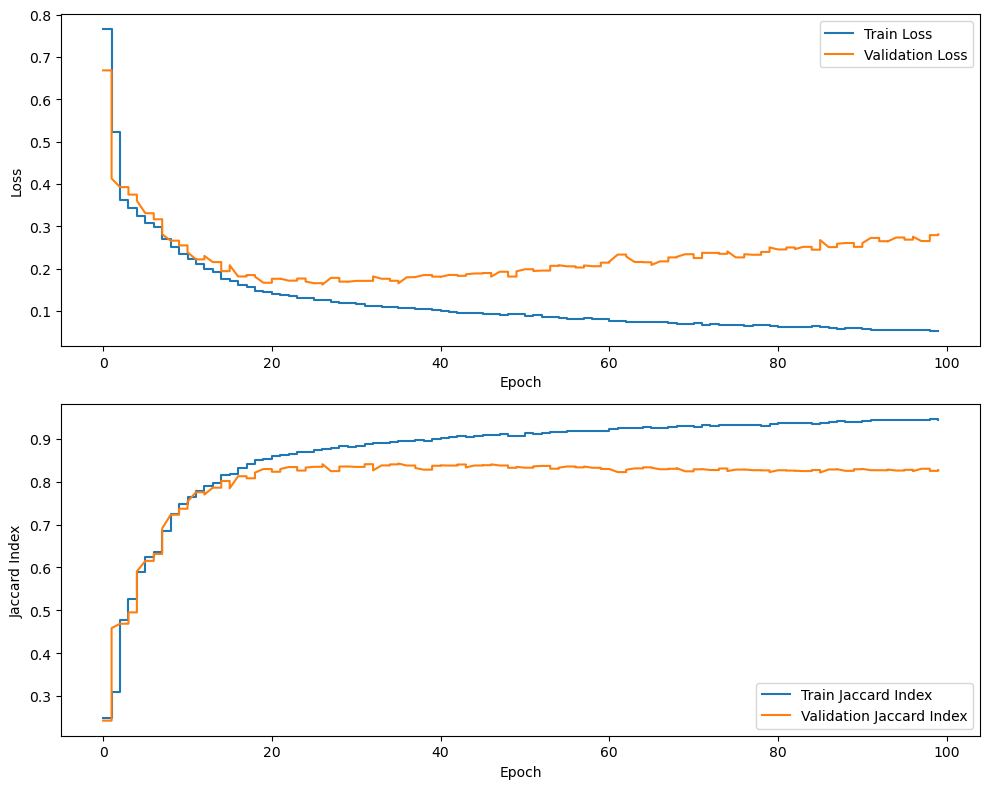

In [15]:
import pandas as pd
#from fnc_unet import plot_training_metrics

metrics = pd.read_csv(os.path.join(logger.log_dir, "metrics.csv"))
metrics = metrics.fillna(method="ffill")
plot_training_metrics(metrics)

In [16]:
from lightning.pytorch.callbacks import EarlyStopping

early_stop_unet_reg = unet_reg_template.create()

early_stop = EarlyStopping(monitor="valArgmaxJI_epoch", mode="max", patience=5)
early_stop_logger = CSVLogger("logs", name="train_until_stagnation")

early_stop_trainer = dl.Trainer(max_epochs=100, logger=early_stop_logger, 
                                callbacks=[early_stop])
early_stop_trainer.fit(early_stop_unet_reg, train_loader, val_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | UNet2d           | 332 K 
5 | optimizer     | Adam             | 0     
---------------------------------------------------
332 K     Trainable params
0         Non-trainable params
332 K     Total par

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/var/folders/hq/wmcbgp7s56b98c9mjf167rz40000gn/T/ipykernel_31136/4256198318.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  metrics = metrics.fillna(method="ffill")


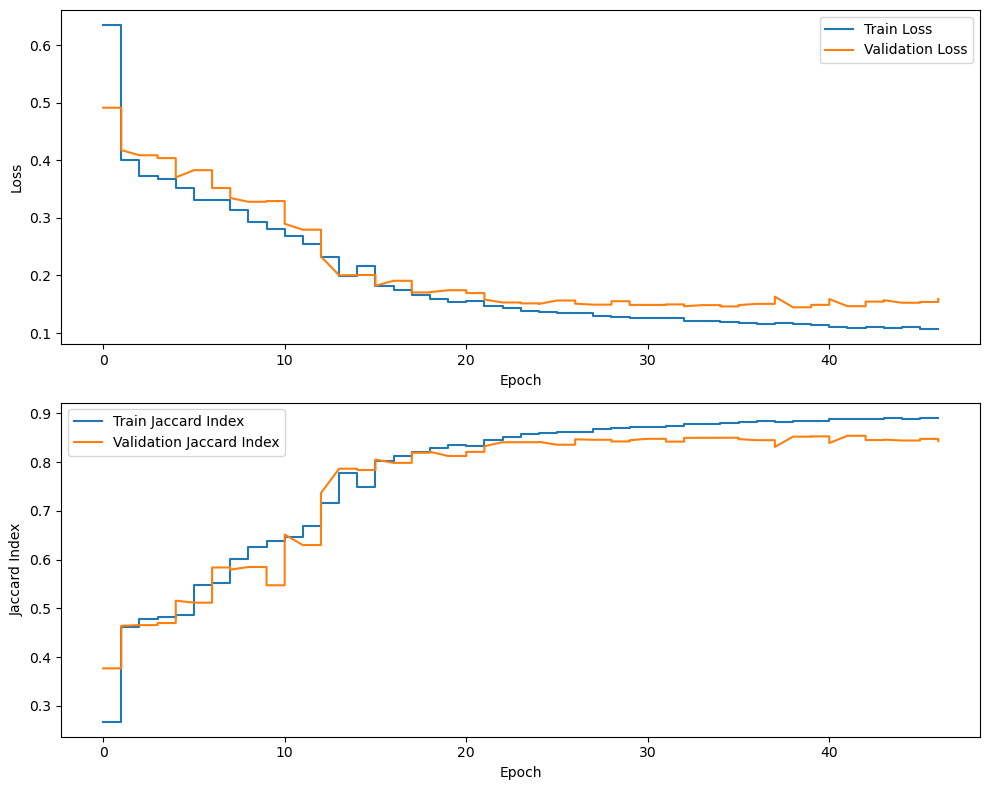

In [17]:
metrics = pd.read_csv(os.path.join(early_stop_logger.log_dir, "metrics.csv"))
metrics = metrics.fillna(method="ffill")
plot_training_metrics(metrics)

## Evaluation

We apply the UNet to the test set 

In [18]:
test_dataset = dt.pytorch.Dataset(pipeline, test_srcs)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

trainer.test(early_stop_unet_reg, test_loader);

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   testArgmaxJI_epoch       0.8585700988769531
     test_loss_epoch        0.14675582945346832
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [19]:
predicted_labels = torch.cat(trainer.predict(early_stop_unet_reg, test_loader), dim=0)

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

We calculate the Jaccard Index, a.k.a. Intersection over Union (IoU) as a metrics to evaluate the results.

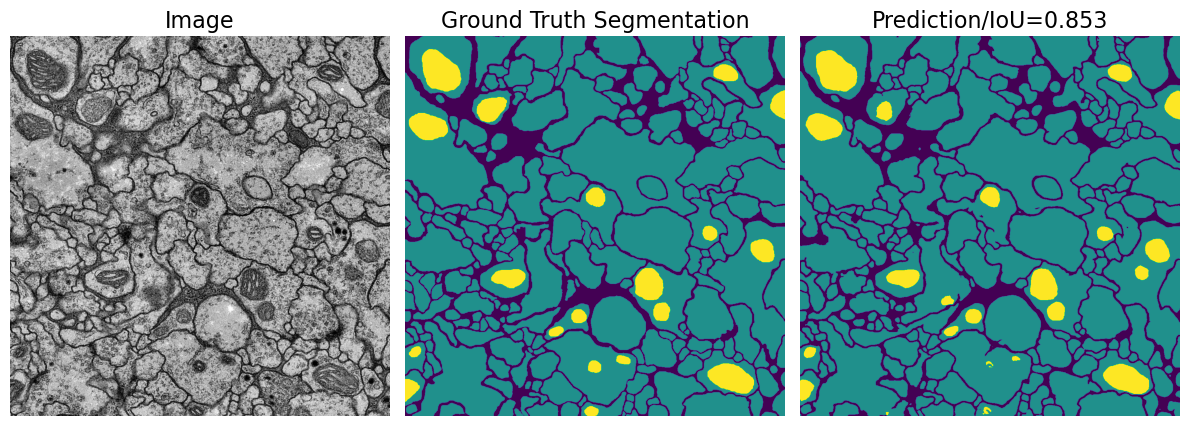

In [20]:
import matplotlib.pyplot as plt

test_image, test_label = test_dataset[0]
ji_metric.reset()
ji_image = ji_metric(predicted_labels[0].unsqueeze(0), test_label.unsqueeze(0))

fig, axs = plt.subplots(1, 3, figsize=((12, 9)))

axs[0].imshow(test_image[0], cmap="gray")
axs[0].set_title("Image", fontsize=16)    
axs[0].set_axis_off()

axs[1].imshow(test_label.argmax(dim=0))
axs[1].set_title("Ground Truth Segmentation", fontsize=16)
axs[1].set_axis_off()

axs[2].imshow(predicted_labels[0].argmax(dim=0))
axs[2].set_title(f"Prediction/IoU={ji_image.numpy():.3f}", fontsize=16)
axs[2].set_axis_off()    

plt.tight_layout()
plt.show()